##### Copyright 2019 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
# Copyright 2019 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# Generating Images with Little Data Using S3GAN


<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/hub/tutorials/s3gan_generation_with_tf_hub"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/s3gan_generation_with_tf_hub.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/hub/blob/master/examples/colab/s3gan_generation_with_tf_hub.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/hub/examples/colab/s3gan_generation_with_tf_hub.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/s?q=s3gan"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub models</a>
  </td>
</table>

This notebook is a demo of Generative Adversarial Networks trained on ImageNet with as little as 2.5% labeled data using self- and semi-supervised learning techniques. Both generator and discriminator models are available on [TF Hub](https://tfhub.dev/s?publisher=google&q=compare_gan).

For more information about the models and the training procedure see our [blogpost](https://ai.googleblog.com/2019/03/reducing-need-for-labeled-data-in.html) and the [paper](https://arxiv.org/abs/1903.02271) [1]. 
The code for training these models is available on [GitHub](https://github.com/google/compare_gan).

To get started, connect to a runtime and follow these steps:

1. (Optional) Select a model in the second code cell below.
2. Click **Runtime > Run all** to run each cell in order.
  * Afterwards, the interactive visualizations should update automatically when you modify the settings using the sliders and dropdown menus.

Note: if you run into any issues, youn can try restarting the runtime and rerunning all cells from scratch by clicking **Runtime > Restart and run all...**.

[1] Mario Lucic\*, Michael Tschannen\*, Marvin Ritter\*, Xiaohua Zhai, Olivier
    Bachem, Sylvain Gelly, [High-Fidelity Image Generation With Fewer Labels](https://arxiv.org/abs/1903.02271), ICML 2019.

## Setup

In [85]:
# @title Imports and utility functions
import os

import IPython
from IPython.display import display
import numpy as np
import PIL.Image
import pandas as pd
import six

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

import tensorflow_hub as hub

def imgrid(imarray, cols=8, pad=1):
  pad = int(pad)
  assert pad >= 0
  cols = int(cols)
  assert cols >= 1
  N, H, W, C = imarray.shape
  rows = int(np.ceil(N / float(cols)))
  batch_pad = rows * cols - N
  assert batch_pad >= 0
  post_pad = [batch_pad, pad, pad, 0]
  pad_arg = [[0, p] for p in post_pad]
  imarray = np.pad(imarray, pad_arg, 'constant')
  H += pad
  W += pad
  grid = (imarray
          .reshape(rows, cols, H, W, C)
          .transpose(0, 2, 1, 3, 4)
          .reshape(rows*H, cols*W, C))
  return grid[:-pad, :-pad]


def imshow(a, format='png', jpeg_fallback=True):
  a = np.asarray(a, dtype=np.uint8)
  if six.PY3:
    str_file = six.BytesIO()
  else:
    str_file = six.StringIO()
  PIL.Image.fromarray(a).save(str_file, format)
  png_data = str_file.getvalue()
  try:
    disp = display(IPython.display.Image(png_data))
  except IOError:
    if jpeg_fallback and format != 'jpeg':
      print ('Warning: image was too large to display in format "{}"; '
             'trying jpeg instead.').format(format)
      return imshow(a, format='jpeg')
    else:
      raise
  return disp


class Generator(object):

  def __init__(self, module_spec):
    self._module_spec = module_spec
    self._sess = None
    self._graph = tf.Graph()
    self._load_model()

  @property
  def z_dim(self):
    return self._z.shape[-1].value

  @property
  def conditional(self):
    return self._labels is not None

  def _load_model(self):
    with self._graph.as_default():
        self._generator = hub.load(self._module_spec)
        
        # Retrieve the structured input signature of the model
        input_signature = self._generator.signatures["default"].structured_input_signature[1]
        
        # Define input tensors based on expected shapes and types
        inputs = {
            key: tf.zeros(shape=spec.shape, dtype=spec.dtype) 
            for key, spec in input_signature.items()
        }
        
        # Generate a sample output by calling the model with these inputs
        self._samples = self._generator.signatures["default"](**inputs)
        
        print("Inputs:", inputs)
        print("Generated output:", self._samples)
        
        # Set self._z and self._labels if present in input keys
        self._z = inputs.get("z")
        self._labels = inputs.get("labels", None)

  def _init_session(self):
    if self._sess is None:
      self._sess = tf.Session(graph=self._graph)
      self._sess.run(tf.global_variables_initializer())

  def get_noise(self, num_samples, seed=None):
    if np.isscalar(seed):
      np.random.seed(seed)
      return np.random.normal(size=[num_samples, self.z_dim])
    z = np.empty(shape=(len(seed), self.z_dim), dtype=np.float32)
    for i, s in enumerate(seed):
      np.random.seed(s)
      z[i] = np.random.normal(size=[self.z_dim])
    return z

  def get_samples(self, z, labels=None):
    with self._graph.as_default():
      self._init_session()

      feed_dict = {self._z: z}
      if self.conditional:
        assert labels is not None
        assert labels.shape[0] == z.shape[0]
        feed_dict[self._labels] = labels

      # Thực hiện suy luận và in ra kết quả trả về từ mô hình
        samples = self._sess.run(self._samples, feed_dict=feed_dict)
        print("Samples dictionary:", samples)  # Xem các khóa trong samples
        
        # Giả sử đầu ra mong muốn nằm trong khóa 'generated'
        generated_samples = samples["generated"]  # Thay 'generated' bằng tên khóa thực tế
        return np.uint8(np.clip(256 * generated_samples, 0, 255))

      # samples = self._sess.run(self._samples, feed_dict=feed_dict)
      # return np.uint8(np.clip(256 * samples, 0, 255))


class Discriminator(object):

  def __init__(self, module_spec):
    self._module_spec = module_spec
    self._sess = None
    self._graph = tf.Graph()
    self._load_model()

  @property
  def conditional(self):
    return "labels" in self._inputs

  @property
  def image_shape(self):
    return self._inputs["images"].shape.as_list()[1:]

  def _load_model(self):
    with self._graph.as_default():
      self._discriminator = hub.Module(self._module_spec, name="disc_module",
                                       tags={"disc", "bsNone"})
      input_info = self._discriminator.get_input_info_dict()
      self._inputs = {k: tf.placeholder(v.dtype, v.get_shape().as_list(), k)
                      for k, v in input_info.items()}
      self._outputs = self._discriminator(inputs=self._inputs, as_dict=True)
      print("Inputs:", self._inputs)
      print("Outputs:", self._outputs)

  def _init_session(self):
    if self._sess is None:
      self._sess = tf.Session(graph=self._graph)
      self._sess.run(tf.global_variables_initializer())

  def predict(self, images, labels=None):
    with self._graph.as_default():
      self._init_session()
      feed_dict = {self._inputs["images"]: images}
      if "labels" in self._inputs:
        assert labels is not None
        assert labels.shape[0] == images.shape[0]
        feed_dict[self._inputs["labels"]] = labels
      return self._sess.run(self._outputs, feed_dict=feed_dict)


## Select a model

In [ ]:
pip install --upgrade tensorflow-hub

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub

# Kiểm tra phiên bản TensorFlow
print("TensorFlow version:", tf.__version__)

# Kiểm tra phiên bản TensorFlow Hub
print("TensorFlow Hub version:", hub.__version__)

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub

# Tải mô hình
module_spec = "https://tfhub.dev/google/compare_gan/s3gan_20_128x128/1"  # Thay thế bằng đường dẫn chính xác của bạn
# Tải mô hình
generator = hub.load(module_spec)

# Kiểm tra các chữ ký của mô hình (nếu có)
print("Available signatures:", generator.signatures.keys())


In [87]:
# @title Select a model { run: "auto" }

model_name = "S3GAN 128x128 20% labels (FID 6.9, IS 98.1)"  # @param ["S3GAN 256x256 10% labels (FID 8.8, IS 130.7)", "S3GAN 128x128 2.5% labels (FID 12.6, IS 48.7)", "S3GAN 128x128 5% labels (FID 8.4, IS 74.0)", "S3GAN 128x128 10% labels (FID 7.6, IS 90.3)", "S3GAN 128x128 20% labels (FID 6.9, IS 98.1)"]
models = {
    "S3GAN 256x256 10% labels": "https://tfhub.dev/google/compare_gan/s3gan_10_256x256/1",
    "S3GAN 128x128 2.5% labels": "https://tfhub.dev/google/compare_gan/s3gan_2_5_128x128/1",
    "S3GAN 128x128 5% labels": "https://tfhub.dev/google/compare_gan/s3gan_5_128x128/1",
    "S3GAN 128x128 10% labels": "https://tfhub.dev/google/compare_gan/s3gan_10_128x128/1",
    "S3GAN 128x128 20% labels": "https://tfhub.dev/google/compare_gan/s3gan_20_128x128/1",
}

module_spec = models[model_name.split(" (")[0]]
print("Module spec:", module_spec)

# tf.reset_default_graph()
tf.compat.v1.reset_default_graph()
print("Loading model...")
sampler = Generator(module_spec)
print("Model loaded.")

Module spec: https://tfhub.dev/google/compare_gan/s3gan_20_128x128/1
Loading model...
Inputs: {'labels': <tf.Tensor 'zeros:0' shape=(64,) dtype=int32>, 'z': <tf.Tensor 'zeros_1:0' shape=(64, 120) dtype=float32>}
Generated output: {'generated': <tf.Tensor 'StatefulPartitionedCall_1:0' shape=(64, 128, 128, 3) dtype=float32>}
Model loaded.


## Sample

Samples dictionary: {'generated': array([[[[0.6440301 , 0.67962676, 0.7262533 ],
         [0.6641512 , 0.7011164 , 0.7670755 ],
         [0.6254022 , 0.6722394 , 0.75676274],
         ...,
         [0.6607281 , 0.70410514, 0.7880325 ],
         [0.7043159 , 0.7576381 , 0.83046603],
         [0.7322547 , 0.77252823, 0.834189  ]],

        [[0.6380863 , 0.6652317 , 0.7539028 ],
         [0.63430053, 0.6623804 , 0.76438737],
         [0.62040925, 0.64611346, 0.75711304],
         ...,
         [0.68209815, 0.716884  , 0.8034396 ],
         [0.67636174, 0.7168907 , 0.80171907],
         [0.6961019 , 0.7318986 , 0.80642384]],

        [[0.65061295, 0.6606036 , 0.7500801 ],
         [0.6389531 , 0.6593413 , 0.74768376],
         [0.6236695 , 0.63901365, 0.74853325],
         ...,
         [0.6614152 , 0.6941041 , 0.78165597],
         [0.6718341 , 0.705037  , 0.7882705 ],
         [0.6840036 , 0.7234372 , 0.7974431 ]],

        ...,

        [[0.05400339, 0.07908052, 0.1437327 ],
         [0

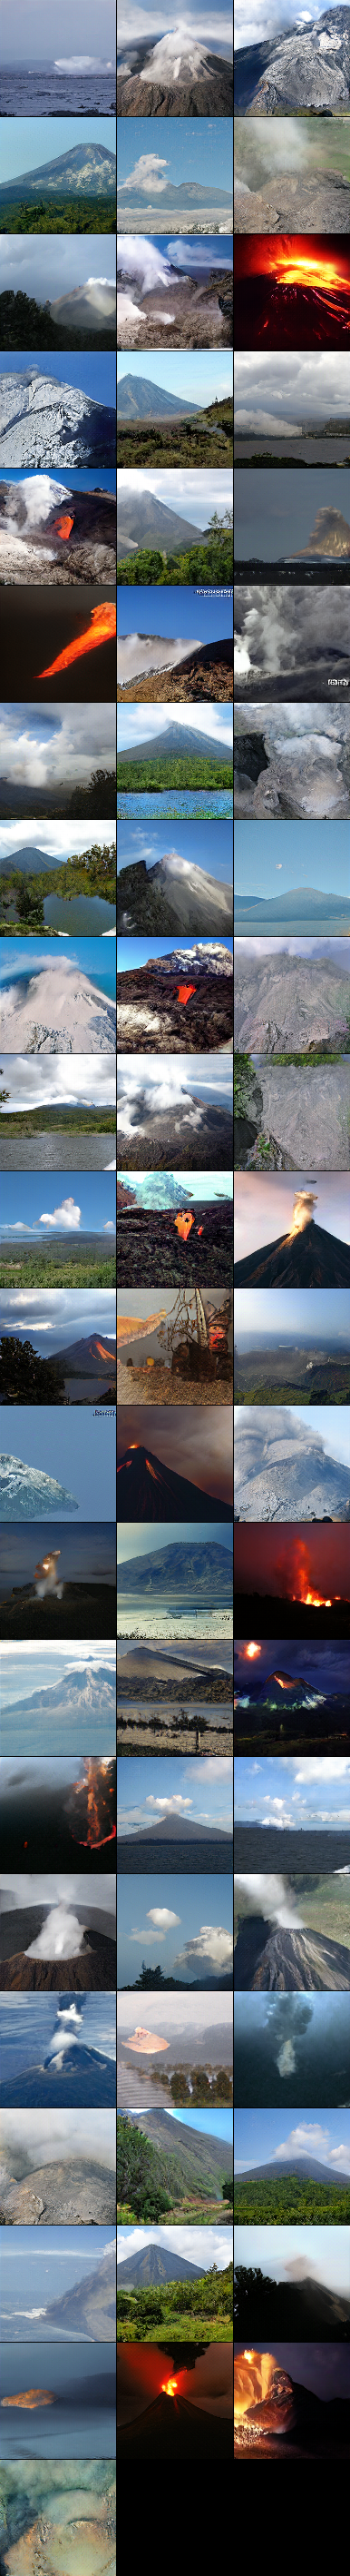

In [89]:
# @title Sampling { run: "auto" }

num_rows = 2  # @param {type: "slider", min:1, max:16}
num_cols = 3  # @param {type: "slider", min:1, max:16}
noise_seed = 23  # @param {type:"slider", min:0, max:100, step:1}
label_str = "980) volcano"  

# num_samples = num_rows * num_cols
num_samples = 64
z = sampler.get_noise(num_samples, seed=noise_seed)

label = int(label_str.split(')')[0])
if label == -1:
  labels = np.random.randint(0, num_classes, size=(num_samples))
else:
  labels = np.asarray([label] * num_samples)

samples = sampler.get_samples(z, labels)
imshow(imgrid(samples, cols=num_cols))

Samples dictionary: {'generated': array([[[[0.89086163, 0.8641954 , 0.86614275],
         [0.96395266, 0.95743525, 0.9465804 ],
         [0.95424   , 0.9368247 , 0.9465096 ],
         ...,
         [0.45183894, 0.45711398, 0.21836007],
         [0.24807307, 0.34097773, 0.20638514],
         [0.26799658, 0.243918  , 0.18897769]],

        [[0.90305054, 0.84621936, 0.8966243 ],
         [0.9647506 , 0.9504091 , 0.95620644],
         [0.9533217 , 0.92884386, 0.95095646],
         ...,
         [0.50671595, 0.43497315, 0.30220246],
         [0.32211828, 0.36499226, 0.38237756],
         [0.26853153, 0.2376343 , 0.16496655]],

        [[0.9400301 , 0.8606559 , 0.9319198 ],
         [0.9475486 , 0.9235221 , 0.9467068 ],
         [0.9555956 , 0.91033   , 0.94701874],
         ...,
         [0.27084273, 0.23809311, 0.09773895],
         [0.55470675, 0.48296553, 0.42724377],
         [0.47575048, 0.3961693 , 0.2755552 ]],

        ...,

        [[0.5546978 , 0.5218471 , 0.4381497 ],
         [0

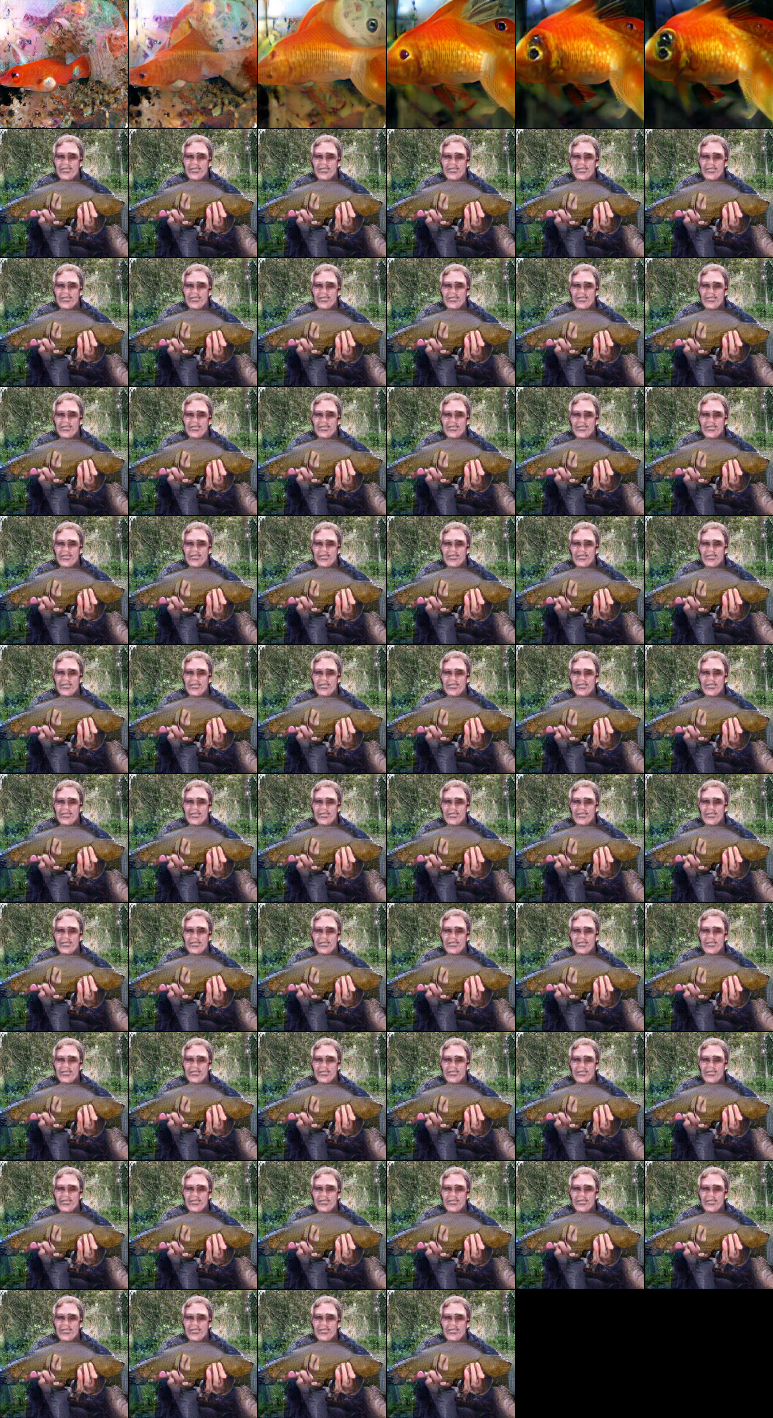

In [90]:
# @title Interpolation { run: "auto" }

num_samples = 1 
num_interps = 6  
noise_seed_A = 11 
noise_seed_B = 0
label_str = "1) goldfish, Carassius auratus"  


def interpolate(A, B, num_interps):
  alphas = np.linspace(0, 1, num_interps)
  if A.shape != B.shape:
    raise ValueError('A and B must have the same shape to interpolate.')
  return np.array([((1-a)*A + a*B)/np.sqrt(a**2 + (1-a)**2) for a in alphas])


def interpolate_and_shape(A, B, num_interps):
  interps = interpolate(A, B, num_interps)
  return (interps.transpose(1, 0, *range(2, len(interps.shape)))
                 .reshape(num_samples * num_interps, -1))

label = int(label_str.split(')')[0])
labels = np.asarray([label] * num_samples * num_interps)


z_A = sampler.get_noise(num_samples, seed=noise_seed_A)
z_B = sampler.get_noise(num_samples, seed=noise_seed_B)
z = interpolate_and_shape(z_A, z_B, num_interps)

target_shape = (64, z.shape[1])  # Kích thước mà mô hình mong đợi (64, 120)
padded_z = np.zeros(target_shape, dtype=z.dtype)
padded_z[:z.shape[0]] = z  # Điền dữ liệu thực tế đến `z.shape[0]`

padded_labels = np.zeros(64, dtype=labels.dtype)
padded_labels[:labels.shape[0]] = labels

samples = sampler.get_samples(padded_z, padded_labels)
imshow(imgrid(samples, cols=num_interps))
# samples = sampler.get_samples(z, labels)
# imshow(imgrid(samples, cols=num_interps))

## Discriminator

In [ ]:
disc = Discriminator(module_spec)

batch_size = 4
num_classes = 1000
images = np.random.random(size=[batch_size] + disc.image_shape)
labels = np.random.randint(0, num_classes, size=(batch_size))

disc.predict(images, labels=labels)

Credit: https://github.com/tensorflow/hub/blob/master/examples/colab/s3gan_generation_with_tf_hub.ipynb